In [1]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt 
import torchvision.utils as vutils
import torchvision.datasets as datasets 

import torchvision.transforms as transforms 

from torch.autograd import Variable
from torchvision.utils import make_grid, save_image

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [3]:
device

device(type='cuda', index=0)

In [4]:
image_size = 64
batch_size = 32
IMAGE_PATH = 'CelebA/img_align_celeba/'

In [5]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                        (0.5, 0.5, 0.5))
])

In [6]:
dataset = datasets.ImageFolder(IMAGE_PATH, transform)
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)

/home/fusemachines/.cache/pypoetry/virtualenvs/poetry-env-H-6CZZOK-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
def weights_init(m):
    classname = m.__class__.__name__  
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:  
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.conv1=nn.Conv2d(3,64,5,padding=2,stride=2)   #in_channels=3
        self.bn1=nn.BatchNorm2d(64,momentum=0.9)
        self.conv2=nn.Conv2d(64,128,5,padding=2,stride=2)
        self.bn2=nn.BatchNorm2d(128,momentum=0.9)
        self.conv3=nn.Conv2d(128,256,5,padding=2,stride=2)
        self.bn3=nn.BatchNorm2d(256,momentum=0.9)
        self.relu=nn.LeakyReLU(0.2)
        self.fc1=nn.Linear(256*8*8,2048)
        self.bn4=nn.BatchNorm1d(2048,momentum=0.9)
        self.fc_mean=nn.Linear(2048,128)
        self.fc_logvar=nn.Linear(2048,128)   #latent dim=128
        
    def forward(self, x):
        batch_size = x.size()[0]
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))  
        out = self.relu(self.bn3(self.conv3(out)))
        out = out.view(batch_size, -1)
        out = self.relu(self.bn4(self.fc1(out)))  
        mean = self.fc_mean(out)
        logvar = self.fc_logvar(out)
        
        return mean, logvar, out

In [9]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.fc1=nn.Linear(128,8*8*256)
        self.bn1=nn.BatchNorm1d(8*8*256,momentum=0.9)
        self.relu=nn.LeakyReLU(0.2)
        self.deconv1=nn.ConvTranspose2d(256,256,6, stride=2, padding=2)
        self.bn2=nn.BatchNorm2d(256,momentum=0.9)
        self.deconv2=nn.ConvTranspose2d(256,128,6, stride=2, padding=2)
        self.bn3=nn.BatchNorm2d(128,momentum=0.9)
        self.deconv3=nn.ConvTranspose2d(128,32,6, stride=2, padding=2)
        self.bn4=nn.BatchNorm2d(32,momentum=0.9)
        self.deconv4=nn.ConvTranspose2d(32,3,5, stride=1, padding=2)
        self.tanh=nn.Tanh()
        
    def forward(self, x):  
        batch_size = x.size()[0]
        x = self.relu(self.bn1(self.fc1(x)))
        x = x.view(-1, 256, 8, 8)
        x=self.relu(self.bn2(self.deconv1(x)))
        x=self.relu(self.bn3(self.deconv2(x)))
        x=self.relu(self.bn4(self.deconv3(x)))
        x=self.tanh(self.deconv4(x))
        return x

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.conv1=nn.Conv2d(3,32,5,padding=2,stride=1)
        self.relu=nn.LeakyReLU(0.2)
        self.conv2=nn.Conv2d(32,128,5,padding=2,stride=2)
        self.bn1=nn.BatchNorm2d(128,momentum=0.9)
        self.conv3=nn.Conv2d(128,256,5,padding=2,stride=2)
        self.bn2=nn.BatchNorm2d(256,momentum=0.9)
        self.conv4=nn.Conv2d(256,256,5,padding=2,stride=2)
        self.bn3=nn.BatchNorm2d(256,momentum=0.9)
        self.fc1=nn.Linear(8*8*256,512)
        self.bn4=nn.BatchNorm1d(512,momentum=0.9)
        self.fc2=nn.Linear(512,1)
        self.sigmoid=nn.Sigmoid()
        
    def forward(self, x): 
        batch_size = x.size()[0]
        x = self.relu(self.conv1(x))
        x = self.relu(self.bn1(self.conv2(x)))
        x = self.relu(self.bn2(self.conv3(x)))
        x = self.relu(self.bn3(self.conv4(x)))
        x = x.view(-1, 256*8*8)
        x1 = x; 
        x = self.relu(self.bn4(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))
        return x, x1

In [11]:
class VAE_GAN(nn.Module):
    def __init__(self):
        super(VAE_GAN, self).__init__()
        self.encoder = Encoder() 
        self.decoder = Decoder()
        self.discriminator = Discriminator() 
        self.encoder.apply(weights_init)
        self.decoder.apply(weights_init)
        self.discriminator.apply(weights_init)
        
    def forward(self, x):
        bs = x.size()[0]
        z_mean, z_logvar, out = self.encoder(x)
        std = z_logvar.mul(0.5).exp_() 
        epsilon = Variable(torch.randn(bs, 128)).to(device)
        z = z_mean + std * epsilon
        x_tilda = self.decoder(z)
        
        return z_mean, z_logvar, x_tilda

In [12]:
gen = VAE_GAN().to(device)

In [13]:
discrim = Discriminator().to(device)

In [14]:
epochs = 1 
lr = 0.001
alpha = 0.1
gamma = 15 

In [15]:
real_batch = next(iter(data_loader))

In [16]:
len(real_batch)

2

In [17]:
real_batch[0].shape

torch.Size([32, 3, 64, 64])

In [18]:
real_batch[1].shape

torch.Size([32])

In [19]:
real_batch[1]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [20]:
z_fixed = Variable(torch.randn((64, 128))).to(device)
x_fixed = Variable(real_batch[0]).to(device)

In [21]:
criterion = nn.BCELoss().to(device)
optim_E = torch.optim.RMSprop(gen.encoder.parameters(), lr=lr)
optim_D = torch.optim.RMSprop(gen.decoder.parameters(), lr=lr)
optim_Dis = torch.optim.RMSprop(discrim.parameters(), lr = lr * alpha)

In [22]:
def show_and_save(file_name, img):
    npimg = np.transpose(img.numpy(), (1, 2, 0))
    f = "./%s.png" % file_name
    fig = plt.figure(dpi = 200)
    fig.suptitle(file_name, fontsize = 12, fontweight = 'bold')
    plt.imshow(npimg)
    plt.imsave(f, npimg)

In [23]:
def plot_loss(loss_list):
    plt.figure(figsize = (10, 5))
    plt.title("Loss During Training")
    plt.plot(loss_list, label = "Loss")
    
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()  

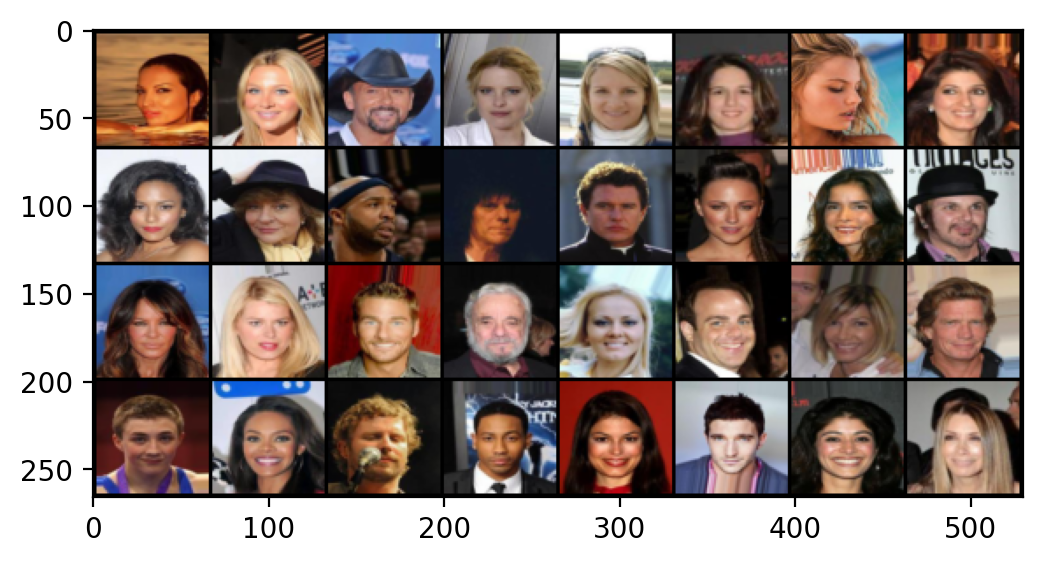

In [24]:
fig = plt.figure(dpi = 200)
plt.imshow(np.transpose(make_grid((x_fixed * 0.5 + 0.5).cpu(), 8).numpy(), (1,2,0)))

In [25]:
import pandas as pd 
import cv2 
import os
df = pd.read_csv("CelebA/img_align_celeba/list_attr_celeba.csv")

In [26]:
df

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
0       000001.jpg                -1                1           1   
1       000002.jpg                -1               -1          -1   
2       000003.jpg                -1               -1          -1   
3       000004.jpg                -1               -1           1   
4       000005.jpg                -1                1           1   
...            ...               ...              ...         ...   
202594  202595.jpg                -1               -1           1   
202595  202596.jpg                -1               -1          -1   
202596  202597.jpg                -1               -1          -1   
202597  202598.jpg                -1                1           1   
202598  202599.jpg                -1                1           1   

        Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  \
0                    -1    -1     -1        -1        -1          -1  ...   
1                     1    -1     -1        -1         1          -1  ...   
2                    -1    -1     -1         1        -1          -1  ...   
3                    -1    -1     -1        -1        -1          -1  ...   
4                    -1    -1     -1         1        -1          -1  ...   
...                 ...   ...    ...       ...       ...         ...  ...   
202594               -1    -1     -1         1        -1          -1  ...   
202595               -1    -1      1         1        -1          -1  ...   
202596               -1    -1     -1        -1        -1           1  ...   
202597               -1    -1     -1         1        -1           1  ...   
202598               -1    -1     -1        -1        -1          -1  ...   

        Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  \
0              -1        1              1         -1                 1   
1              -1        1             -1         -1                -1   
2              -1       -1             -1          1                -1   
3              -1       -1              1         -1                 1   
4              -1       -1             -1         -1                -1   
...           ...      ...            ...        ...               ...   
202594         -1       -1             -1         -1                -1   
202595         -1        1              1         -1                -1   
202596         -1        1             -1         -1                -1   
202597         -1        1             -1          1                 1   
202598         -1       -1             -1          1                -1   

        Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  \
0                -1                 1                -1               -1   
1                -1                -1                -1               -1   
2                -1                -1                -1               -1   
3                -1                 1                 1               -1   
4                -1                 1                -1               -1   
...             ...               ...               ...              ...   
202594           -1                 1                -1               -1   
202595           -1                -1                -1               -1   
202596           -1                -1                -1               -1   
202597           -1                 1                -1               -1   
202598           -1                 1                -1               -1   

        Young  
0           1  
1           1  
2           1  
3           1  
4           1  
...       ...  
202594      1  
202595      1  
202596      1  
202597      1  
202598      1  

[202599 rows x 41 columns]

In [27]:
feature_dict = {k:v for v, k in enumerate(df.columns)}

In [28]:
feature_dict

{'image_id': 0,
 '5_o_Clock_Shadow': 1,
 'Arched_Eyebrows': 2,
 'Attractive': 3,
 'Bags_Under_Eyes': 4,
 'Bald': 5,
 'Bangs': 6,
 'Big_Lips': 7,
 'Big_Nose': 8,
 'Black_Hair': 9,
 'Blond_Hair': 10,
 'Blurry': 11,
 'Brown_Hair': 12,
 'Bushy_Eyebrows': 13,
 'Chubby': 14,
 'Double_Chin': 15,
 'Eyeglasses': 16,
 'Goatee': 17,
 'Gray_Hair': 18,
 'Heavy_Makeup': 19,
 'High_Cheekbones': 20,
 'Male': 21,
 'Mouth_Slightly_Open': 22,
 'Mustache': 23,
 'Narrow_Eyes': 24,
 'No_Beard': 25,
 'Oval_Face': 26,
 'Pale_Skin': 27,
 'Pointy_Nose': 28,
 'Receding_Hairline': 29,
 'Rosy_Cheeks': 30,
 'Sideburns': 31,
 'Smiling': 32,
 'Straight_Hair': 33,
 'Wavy_Hair': 34,
 'Wearing_Earrings': 35,
 'Wearing_Hat': 36,
 'Wearing_Lipstick': 37,
 'Wearing_Necklace': 38,
 'Wearing_Necktie': 39,
 'Young': 40}

In [29]:
from torch.utils.data import Dataset

In [30]:
class CelebADataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, attribute, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.celeb_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.attribute = attribute
        self.transform = transform
        self.pic_size = 64

    def __len__(self):
        return len(self.celeb_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                self.celeb_df.loc[idx]["image_id"])
#         image = Image.open(img_name).convert('RGB').resize((self.pic_size, self.pic_size))
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.pic_size, self.pic_size))
        labels = self.celeb_df.loc[idx][self.attribute]
        
        sample = {'image': image, 'labels': labels}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

In [31]:
transform = transforms.Compose([
#     transforms.Scale(image_size),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [112]:
path = "CelebA/img_align_celeba/img_align_celeba/"
csv_file = "CelebA/img_align_celeba/list_attr_celeba.csv"
celeb_dataset = CelebADataset(csv_file=csv_file, root_dir=path, attribute="Mustache", transform=transforms.Compose([
                                               transforms.ToTensor(),
                                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                                                transforms.ToPILImage()
                                           ]))

In [113]:
dataloader = torch.utils.data.DataLoader(celeb_dataset, batch_size=2,
                        shuffle=True, num_workers=0)

In [114]:
gen.load_state_dict(torch.load('gen68.pth', map_location=device))

<All keys matched successfully>

In [115]:
discrim.load_state_dict(torch.load('discrim68.pth', map_location=device))

<All keys matched successfully>

In [117]:
mustache = []
non_mustache = []
for i_batch, sample_batched in enumerate(dataloader):
    mean, logvar, val = gen.encoder(sample_batched['image'].to(device))
    std = logvar.mul(0.5).exp_() 
    epsilon = Variable(torch.randn(2, 128)).to(device)
    z = mean + std * epsilon
    z = z.detach()
    for i in sample_batched['labels']:
        if i == 1:
            mustache.append(z[i])
        else:
            non_mustache.append(z[i])
    if i_batch == 100000:
        break

In [118]:
tmustache = torch.stack(mustache)
tmustache = torch.mean(tmustache, dim=0)
tnon_mustache = torch.stack(non_mustache)
tnon_mustache = torch.mean(tnon_mustache, dim=0)
feat_mustache = tmoustache - tnon_mustache

In [119]:
def show_and_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    fig = plt.figure(dpi=200)
    fig.suptitle(file_name, fontsize=14, fontweight='bold')
    plt.imshow(npimg)
#     plt.imsave(f,npimg)

In [120]:
def visualize_reconstructions(datav, b, c):
    # Reconstruct images
#     datav = datav.cpu()
    # Plotting
    imgs = torch.stack([datav.to('cpu'), b.to('cpu'), c.to('cpu')], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=9, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(20,20))
    plt.title(f"Actual image Vs Reconstructed image Vs feat added image")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [102]:
f_must = torch.ones(128)

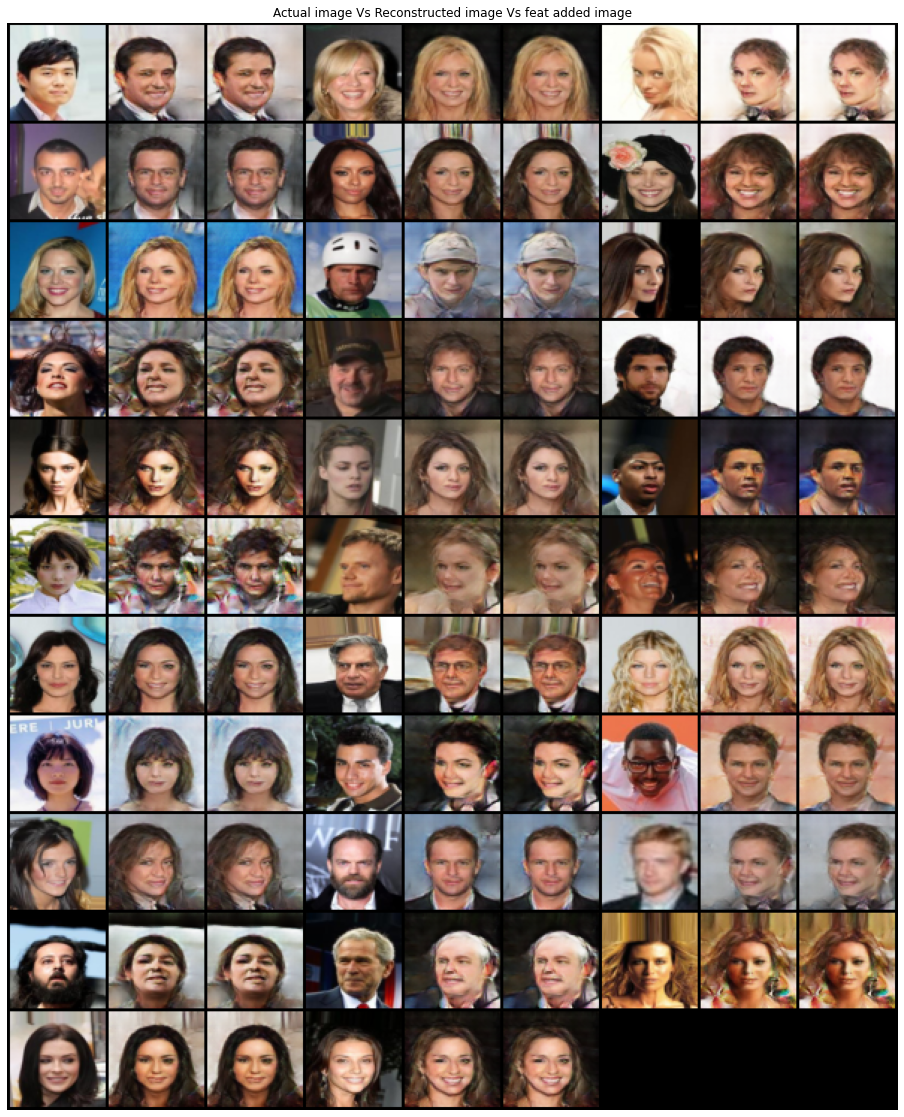

In [123]:
for epoch in range(epochs):
    for i, (data, _) in enumerate(data_loader, 0):
        datav = Variable(data).to(device)
        
        mean, logvar, rec_enc_dec = gen.encoder(datav)
        std = logvar.mul(0.5).exp_() 
        epsilon = Variable(torch.randn(32, 128)).to(device)
        y = mean + std * epsilon
        rec_enc_dec_moustache = y + feat_mustache.to(device)
        b = gen.decoder(y).detach()
        c = gen.decoder(rec_enc_dec_moustache).detach()

        visualize_reconstructions(datav, b, c)

        break

In [51]:
path = "CelebA/img_align_celeba/img_align_celeba/"
csv_file = "CelebA/img_align_celeba/list_attr_celeba.csv"
eye_celeb_dataset = CelebADataset(csv_file=csv_file, root_dir=path, attribute="Eyeglasses", transform=transforms.Compose([
                                               transforms.ToTensor(),
#                                                transforms.ToPILImage()
                                           ]))

In [52]:
eye_dataloader = torch.utils.data.DataLoader(celeb_dataset, batch_size=4,
                        shuffle=True, num_workers=0)

In [55]:
eyeglasses = []
non_eyeglasses = []
for i_batch, sample_batched in enumerate(eye_dataloader):
    z = gen.encoder(sample_batched['image'].to(device))[2].detach().to('cpu')
    for i in sample_batched['labels']:
        if i == 1:
            eyeglasses.append(torch.mean(z, dim=0))
        else:
            non_eyeglasses.append(torch.mean(z, dim=0))
    if i_batch == 10000:
        break

In [56]:
teyeglasses = torch.stack(eyeglasses)
teyeglasses = torch.mean(teyeglasses, dim=0)
tnon_eyeglasses = torch.stack(non_eyeglasses)
tnon_eyeglasses = torch.mean(tnon_eyeglasses, dim=0)
feat_eyeglasses = teyeglasses - tnon_eyeglasses

In [57]:
teyeglasses

tensor([-0.0043, -0.0017, -0.0040,  ..., -0.0031,  0.0019,  0.0018])

In [58]:
tnon_eyeglasses

tensor([-0.0043, -0.0017, -0.0040,  ..., -0.0031,  0.0018,  0.0018])

In [59]:
feat_eyeglasses.shape

torch.Size([2048])

In [60]:
feat_eyeglasses = torch.ones(2048)

In [61]:
feat_eyeglasses.shape

torch.Size([2048])

tensor([-0.0038, -0.0017, -0.0055,  ..., -0.0065,  0.0173, -0.0020],
       device='cuda:0', grad_fn=<SelectBackward>)
tensor([0.9962, 0.9983, 0.9945,  ..., 0.9935, 1.0173, 0.9980], device='cuda:0',
       grad_fn=<SelectBackward>)


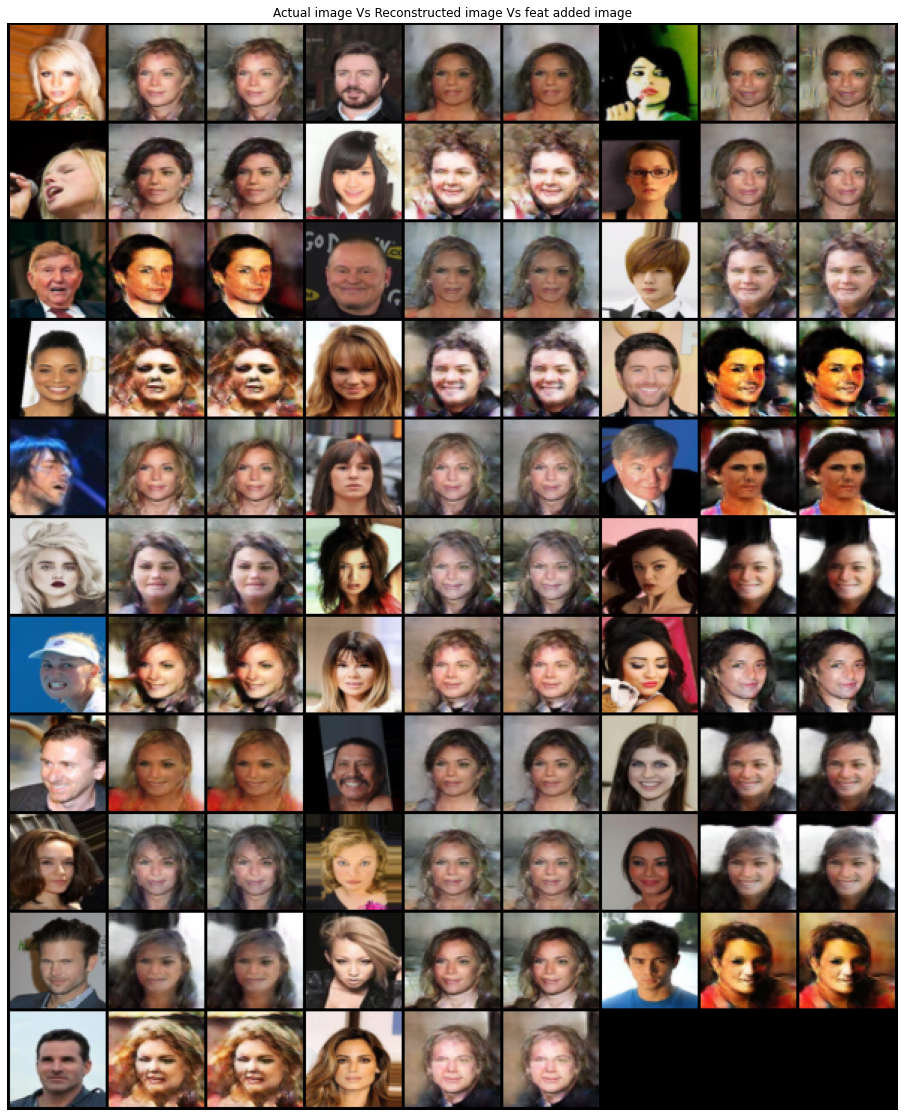

In [62]:
for epoch in range(epochs):
    for i, (data, _) in enumerate(data_loader, 0):
        datav = Variable(data).to(device)
        
        mean, logvar, rec_enc_dec = gen.encoder(datav)
        z_p = Variable(torch.randn(64,128)).to(device)
        print(rec_enc_dec[0])
        rec_enc_dec_moustache = rec_enc_dec + feat_eyeglasses.to(device)
        print(rec_enc_dec_moustache[0])
        b = gen.decoder(rec_enc_dec)
        c = gen.decoder(rec_enc_dec_moustache)
        
        visualize_reconstructions(datav, b, c)

        break

In [57]:
def visualize_reconstructions_two_images(datav, b):
    # Reconstruct images
#     datav = datav.cpu()
    # Plotting
    imgs = torch.stack([datav.to('cpu'), b.to('cpu')], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=8, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(20,20))
    plt.title(f"Actual image Vs Reconstructed image")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

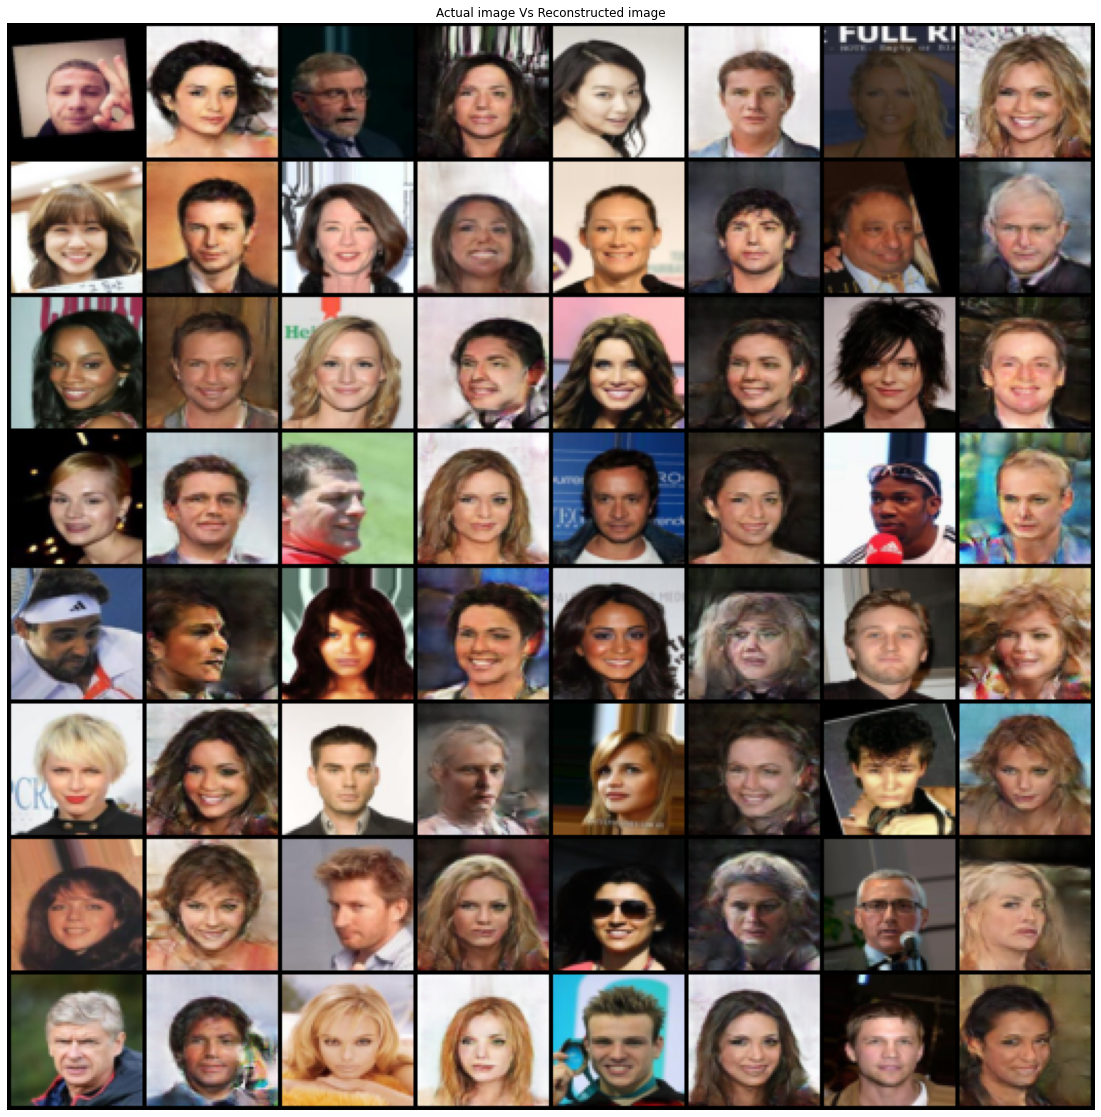

In [58]:
b=gen(x_fixed)[2]
b=b.detach()
c=gen.decoder(z_fixed)
c=c.detach()
visualize_reconstructions_two_images(datav, b)

# show_and_save('celebA_noise_results/Celebrec_noise_epoch_%d' % epoch ,make_grid((c*0.5+0.5).cpu(),8))
# show_and_save('celebA_results/Celebrec_epoch_%d' % epoch ,make_grid((b*0.5+0.5).cpu(),8))